## Analyzing the Impact of Agricultural Policies on Population Health in the United States

<h3> The Problem </h3>


Our aim is to understand if **agricultural policies** in the US are increasing the average calorie intake per person in the US, resulting in increased obesity and decreased population health.
<h3>Population Health</h3>


An ideal <a href="https://en.wikipedia.org/wiki/Population_health">population health</a> outcome metric should reflect a population’s dynamic state of physical, mental, and social well-being. <font color='green'>Positive health</font> outcomes include being **alive**; functioning well **mentally, physically, and socially**; and having a sense of **well-being**. <font color='red'>Negative</font> outcomes include **death**, **loss of function**, and **lack of well-being**. In contrast to these health outcomes, diseases and injuries are intermediate factors that influence the likelihood of achieving a state of health. On the basis of a review of outcomes metrics currently in use and the availability of data for at least some US counties,the following metrics for population health outcomes are recommended: 

1. Life expectancy from birth, or age-adjusted mortality rate.
2. Condition-specific changes in life expectancy, or condition-specific or age-specific mortality rates 
3. Self-reported level of health, functional status, and experiential status. 

When reported, outcome metrics should present both the overall level of health of a population and the distribution of health among different geographic, economic, and demographic groups in the population.

In this project, we use measures such as - 
1. Death Rate by *state*
2. Death Rate due to *endocrine and nutritional issues by state*
3. Obesity Levels by *state and demographics*

as a measure of **poplulation health**.

<h3>Agricultural Policies</h3>

The agricultural policies in the US are generally referred to as <a href="https://www.ers.usda.gov/agricultural-act-of-2014-highlights-and-implications/">farm bill</a>. The latest farm bill was introduced in 2014 and a new bill is due in 2019.

The model the agricultural policies, we use the following variables - 

1. Corn Prices (\$/bushel) by *state*
2. Soybean Prices (\$/bushel) by *state*
3. Subsidies going to corn and soybean productions

In addition to that we will also include the qualitative analysis on the growth of fast food consumption and the price of fast food in the US.

### Importing libraries

In [ ]:
#####################################################################
# Data visualization using Bokeh
#####################################################################
import bokeh
from bokeh.io import show
from bokeh.io import output_notebook
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.palettes import small_palettes as small_palettes
from bokeh.plotting import figure
from bokeh.models import CustomJS, Slider, Legend, LegendItem
from bokeh.layouts import row, widgetbox
from bokeh.sampledata.us_states import data as states
from bokeh.models import LinearColorMapper, LinearScale, ColorBar

#####################################################################
# Basic Python libs
#####################################################################

import csv
import sqlite3
import pandas as pd
import numpy as np
import math
import matplotlib

from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import interactive

matplotlib.use("svg")

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

output_notebook()

## The Data Sources

The availability agricultural data is quite abundant and we leveraged several such sources to get our data.

1. Death rate data - <a href="https://wonder.cdc.gov/">Center for Disease Control</a> - 2000 rows
2. Agricultural Data - <a href="https://data.ers.usda.gov/FEED-GRAINS-custom-query.aspx">USDA</a> - 438697 rows
3. Obesity data - <a href="https://catalog.data.gov/dataset?tags=obesity"> DATA.gov</a> - 53392 rows


### Unix Area

In [2]:
datadir = "../data/"
!ls -lrt ../data

total 415880
-rw-r--r--@ 1 rohansingh  staff  81131198 Mar  9 08:49 FeedGrains.csv
-rw-r--r--@ 1 rohansingh  staff   4773458 Apr 12 00:18 FeedGrains.zip
-rw-r--r--  1 rohansingh  staff  79233024 Apr 12 00:28 feedgrain.db
-rw-r--r--  1 rohansingh  staff         0 Apr 12 01:01 FeedGrains.db
-rw-r--r--@ 1 rohansingh  staff    151999 Apr 16 21:47 Analysis_Tableau.twb
-rw-r--r--@ 1 rohansingh  staff     64517 Apr 16 22:30 Analysis_Tableau_AdCampaign.twb
-rw-r--r--@ 1 rohansingh  staff     37081 Apr 24 20:27 tax_per_operation_by_state_corn.csv
-rw-r--r--@ 1 rohansingh  staff   1607687 May  6 18:16 death_rate_data_1999_2016.txt
-rw-r--r--@ 1 rohansingh  staff     49268 May  6 18:34 death_rate_by_state_year.txt
-rw-r--r--@ 1 rohansingh  staff     50546 May  6 19:21 death_nutrional_endocrine_by_state_year.txt
-rw-r--r--@ 1 rohansingh  staff  20397291 May  8 10:24 nutrition_physical_activity_raw.csv.backup
-rw-r--r--  1 rohansingh  staff     58833 May  8 10:31 obesity_data_by_state_year.csv
-rw-

### Cleaning the data retrieved from CDC website.

In [13]:
"""
This subroutine cleans and formats data.
"""
def clean_data(filename, **kwargs):
    """
    Takes a filenane to generate clean data for data retrieved from CDC.
    Args:
        filename : Raw filename downloaded from CDC website
        **kwargs['remove_cols'] : Columns that need to dropped
    Returns:
        df : clean dataframe
    """
    
    df = pd.read_csv(datadir + filename, sep="\t")
    df = df[df['Notes'].isnull()]
    df = df.drop('Notes', axis=1)
    df = df.drop(kwargs['remove_cols'], axis=1)
    # death_rate_data = death_rate_data[death_rate_data['Crude Rate'] != 'Unreliable']
    df['Crude Rate'] = df['Crude Rate'].astype(float)
    df['Year'] = df['Year'].astype(int)
    return df

In [14]:
"""
This subroutine helps visualize a data value for all states and years
"""
def plot_all_states(df):
    """
    Args:
        df(dataframe) : a dataframe consisting of year, state, and value column.
    Outputs:
        plot showing value for all states
    """
    legend = []
    plt.figure(figsize=(15,10))
    for state in df['State'].unique():
        df1 = df[df['State'] == state]
        plt.plot(df1['Year'], df1['Crude Rate'])
        legend.append(state)
    plt.xticks(df['Year'].unique())
    plt.legend(legend,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Death rate by state

We see here that the death rate across states have been fairly constant over the years for all the states. 

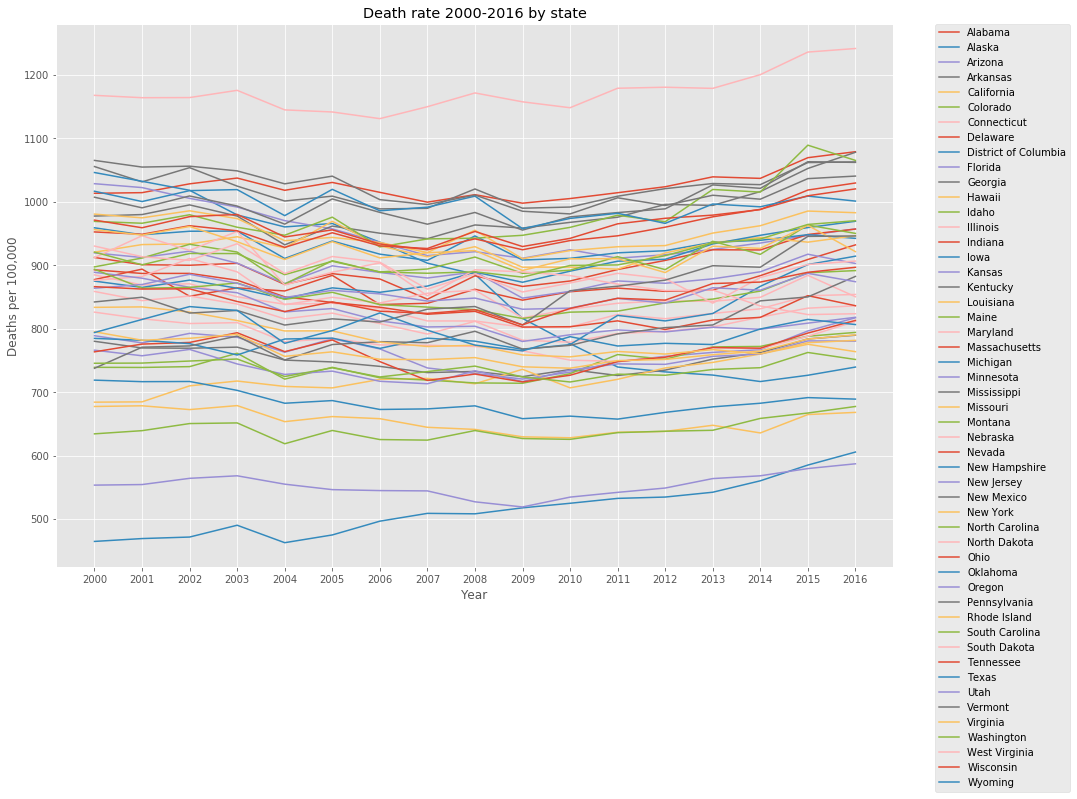

In [15]:
death_rate_state_year = clean_data('death_rate_by_state_year.txt', remove_cols=['State Code', 'Year Code'])
plot_all_states(death_rate_state_year)
plt.xlabel("Year")
plt.ylabel("Deaths per 100,000")
plt.title("Death rate 2000-2016 by state");

### Death rate by nutrional and endocrine by state

,Year,State,Deaths,Population,Crude Rate
0,1999,Alabama,1772.0,4430141.0,40.0
1,1999,Alaska,88.0,624779.0,14.1
2,1999,Arizona,1370.0,5023823.0,27.3
3,1999,Arkansas,967.0,2651860.0,36.5
4,1999,California,8219.0,33499204.0,24.5


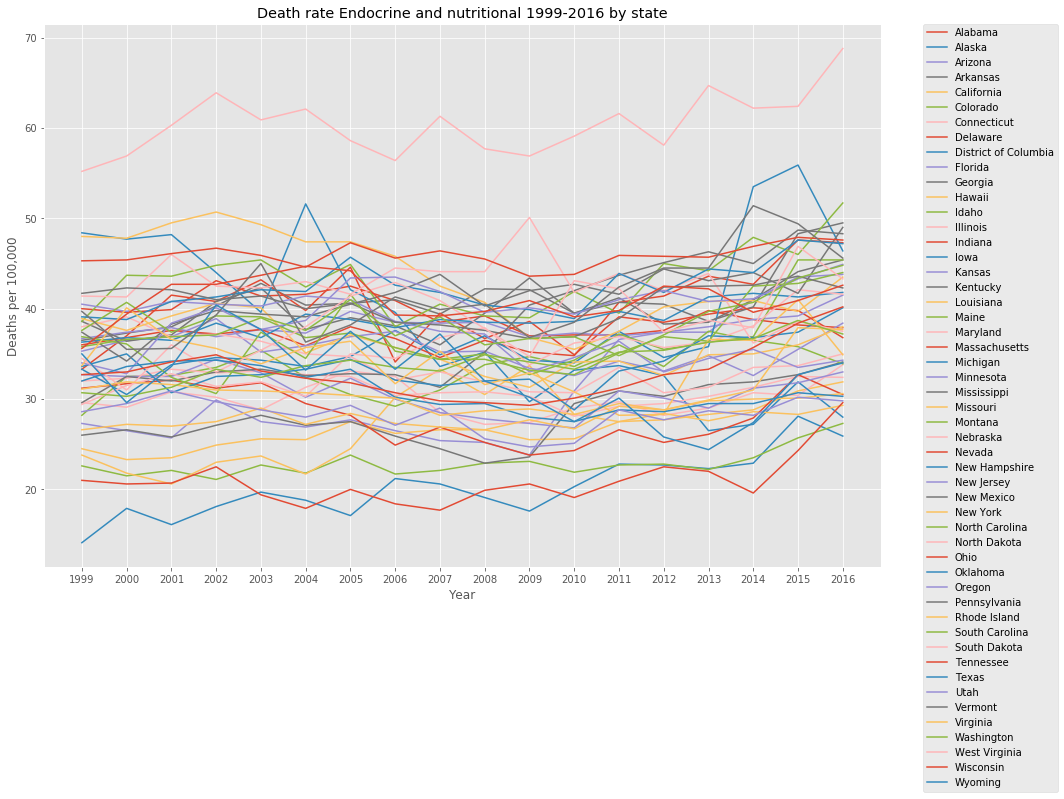

In [16]:
death_nutritional_state_year = clean_data('death_nutrional_endocrine_by_state_year.txt', 
                                          remove_cols=['State Code', 'Year Code'])
plot_all_states(death_nutritional_state_year)
plt.xlabel("Year")
plt.ylabel("Deaths per 100,000")
plt.title("Death rate Endocrine and nutritional 1999-2016 by state");
death_nutritional_state_year.head()

### Widget to plot each state separately

Next we wanted to delve deeper into data for each state for deaths. For this we created a widget for exploring the statewise data for states using a dropdown menu.

In [17]:
"""
This subroutine is used by an interactive widget to plot the rates given a state.
"""
def plot_state(df,state):
    """
    Args:
        df (dataframe) :  a dataframe consisting of year, state, and value column.
        state : the state for which the interactive plot is shown.
    Outputs:
        Show a matplotlib plot
    """
    min_cr = min(df['Crude Rate'])
    max_cr = max(df['Crude Rate'])
    df1 = df[df['State'] == state]
    plt.plot(df1['Year'], df1['Crude Rate'])
    plt.legend([state])
    plt.xlim(2000,2016)
    plt.ylim(min_cr,max_cr)
    plt.xlabel("Year")
    plt.ylabel("Deaths per 100,000")
    plt.show()
    

### View death rate by state ( Interactivily )

In [18]:
l = [(k,k) for k in death_rate_state_year['State'].unique()]
w = widgets.Select(options=l,description='Select State:')
state = 'Alabama'
    
interactive_plot = interactive(plot_state, df=fixed(death_rate_state_year),state=l)
interactive_plot

### View deaths due to nutrition (broad category) 

In [19]:
l = [(k,k) for k in death_nutritional_state_year['State'].unique()]
w = widgets.Select(options=l,description='Select State:')
state = 'Alabama'
    
interactive_plot = interactive(plot_state, df=fixed(death_nutritional_state_year),state=l)
interactive_plot

The interactive map was used to see trends pertaining to states and death rate changes over the years. We found that endocrine and nutrition related deaths have been increasing.

## Visualize state wise data on static map

Next, to see how the data is spread across the United States, we wrote a subroutine to show different rates on a map.
For this task, we utilized the amazing python data visualization library called "Bokeh"

In [10]:
def plot_on_map(df, max_rate=0, min_rate=100,year=2015):
    """
    Plot Data on the an interactive US MAP
    """
    
    EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")
    color_mapper = LinearColorMapper(palette=palette, high=max_rate, low=min_rate)
    
    for state in EXCLUDED:
        if state.upper() in states:
            del states[state.upper()]
            
   # palette.reverse()
    state_codes = {
        code: state for code, state in states.items() if state not in EXCLUDED
    }

    state_xs = [states[code]["lons"] for code in state_codes]
    state_ys = [states[code]["lats"] for code in state_codes]
    state_names = [state['name'] for state in state_codes.values()]
    color_mapper = LinearColorMapper(palette=palette, high=max_rate, low=min_rate)

    state_rates = [df[(df['State']==state_codes[state_id]['name']) 
                                   & (df['Year']==year)]['Crude Rate'] for state_id in state_codes]

    dummy = np.random.randn(len(state_rates))
    years1 = pd.DataFrame({'year': str(year) , 'dummy': dummy})
    years1 = years1.drop(['dummy'], axis=1)
    years1 = years1['year']

    source = ColumnDataSource(data=dict(
        x=state_xs,
        y=state_ys,
        name=state_names,
        rate=state_rates,
        year = years1
    ))

    TOOLS = "pan,wheel_zoom,reset,save"
    
    p = figure(
        title="State-wise crude death rates {}".format(year),tools=TOOLS,
        x_axis_location=None, y_axis_location=None, plot_width=250, plot_height=250
        
    )
    p.grid.grid_line_color = None

    p.patches('x', 'y', source=source,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("Name", "@name"),
        ("Crude Death Rate", "@rate"),
        ("Year", "@year"),
    ]
    
    return p


### Visualizing data over the year on a map

We also figured data to analyze the impact of policies on health, we need a tool to go over years of data and see which places are most affected. This is required for doing a root cause analysis of the problem.

In [31]:
def plot_on_map_with_slider(df, max_rate, min_rate,title="Crude Death Rates"):
    """
    Plot CDC Data on the US Map with year slider
    """
    
    EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")
    
    for state in EXCLUDED:
        if state.upper() in states:
            del states[state.upper()]
            
    small_palettes['Reds'][9].reverse()
    states_dict = {
        code: state for code, state in states.items() if str(state).lower() not in EXCLUDED
    }
    state_xs = [states_dict[code]["lons"] for code in states_dict]
    state_ys = [states_dict[code]["lats"] for code in states_dict]
    
    state_names = [state['name'] for state in states_dict.values()]
    color_mapper = LinearColorMapper(palette=small_palettes['Reds'][9], high=max_rate, low=min_rate)

    sources = {}
    years = np.sort(np.unique(df['Year']))
    rate_years = {str(v): [df[(df['State']==states[state_id]['name']) 
                               & (df['Year']==v)]['Crude Rate'] for state_id in states] 
              for i, v in enumerate(years)}

    source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    name=state_names,
    rate=rate_years[str(years[0])],
    **rate_years
))

    TOOLS = "pan,wheel_zoom,reset,save"

    p = figure(
        title=title, tools=TOOLS,
        x_axis_location=None, y_axis_location=None
    )
    p.grid.grid_line_color = None

    p.patches('x', 'y', source=source,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    color_mapper = LinearColorMapper(palette=small_palettes['Reds'][9], low=min_rate, high=max_rate)
    color_bar = ColorBar(color_mapper=color_mapper, 
                 label_standoff=12, border_line_color=None, location=(0,0))
    p.add_layout(color_bar, 'right')
    

    callback = CustomJS(args=dict(source=source), code="""
        var year = year.value;
        var data = source.data;
        var col = ''+year
        data['rate'] = data[col]
        source.change.emit();
    """)

    year_slider = Slider(start=years[0], end=years[-1], value=years[0], step=1,
                        title="Year", callback=callback)
    callback.args["year"] = year_slider

    layout = row([p,year_slider])

    show(layout)


### Change in death rate over years in the US

In [33]:
max_cr = max(death_rate_state_year['Crude Rate'])
min_cr = min(death_rate_state_year['Crude Rate'])
plot_on_map_with_slider(death_rate_state_year, max_cr, min_cr)
# show(plot_on_map(death_nutritional_state_year, max_cr, min_cr))

### Visualizing nutrition and endocrine related deaths

It is noticeable to see that the nutrition and endocrine related deaths have increase a lot since 2014 across several states. Also, the new farm bill was introduced in 2014. This made our **belief stronger** that **farm policies** have some correlation with **polulation health**

In [35]:
max_cr = max(death_nutritional_state_year['Crude Rate'])
min_cr = min(death_nutritional_state_year['Crude Rate'])
plot_on_map_with_slider(death_nutritional_state_year, max_cr, min_cr, title = "Nutrition or Endocrine related deaths")
# show(plot_on_map(death_nutritional_state_year, max_cr, min_cr))

### Obesity Data

Across the United States, more than 33% of the adults are obese and more than 16% of children (aged 2-19) are obese. It is one of the biggest health issues facing the nation with about 70% of the country's officials ranking it as the leading issue in their areas [https://stateofobesity.org/obesity-rates-trends-overview/].

We have selected obesity rates by states as our main indicator for public health. The data has been curated from the Centers for Disease Control and Prevention <a href="www.CDC.gov">website</a>. While there are other factors that affect obesity, as you will see in our analysis below, consumption of high caloric food is a major contributing factor.


#### Analyis of Obesity data

In [49]:
raw_obesity = pd.read_csv(datadir + 'nutrition_physical_activity_raw.csv')

In [47]:
### DO NOT CHANGE THIS CELL ###
def clean_obesity(df):
    """
    This subroutine cleans the nutrition and physical activity report that we get from data.gov
    """
    df = df[df['Data_Value_Footnote'].isnull()]
    df = df.drop(["YearEnd", 'Datasource', 'Class', 'Topic', 'Data_Value_Unit','Data_Value_Type',
                    'Data_Value_Alt', 'Data_Value_Footnote', 'Data_Value_Footnote_Symbol','Low_Confidence_Limit',
                     'High_Confidence_Limit ', 'Sample_Size', 'GeoLocation','ClassID','TopicID',
                      'DataValueTypeID','LocationID'], axis = 1)
    df_us = df[df['Total'] == 'Total']
    df_states = df[df['Total'] != 'Total']
    return df_us, df_states

In [52]:
obesity_us, obesity_states = clean_obesity(raw_obestity)
obesity_states.head()

,YearStart,LocationAbbr,LocationDesc,Question,Data_Value,Total,Age(years),Education,Gender,Income,Race/Ethnicity,QuestionID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
1,2011,AL,Alabama,Percent of adults aged 18 years and older who ...,32.3,NaN,NaN,NaN,Male,NaN,NaN,Q036,Gender,Male,GEN,MALE
2,2011,AL,Alabama,Percent of adults aged 18 years and older who ...,31.8,NaN,NaN,NaN,Female,NaN,NaN,Q036,Gender,Female,GEN,FEMALE


As you can see from the table above, the data is divided into various stratification categories, like gender, education, race, etc. Each stratification category has various criteria for stratification. For example, the category education is divides the population into people based on the maximum level of education that they have received, where as the category gender is only split into males and females.

In [53]:
question_map = dict(zip(obesity_states['QuestionID'],obesity_states['Question']))
obesity_states_features = obesity_states.drop(['Question', 'Total'], axis = 1)
question_map

{'Q018': 'Percent of adults who report consuming fruit less than one time daily',
 'Q019': 'Percent of adults who report consuming vegetables less than one time daily',
 'Q036': 'Percent of adults aged 18 years and older who have obesity',
 'Q037': 'Percent of adults aged 18 years and older who have an overweight classification',
 'Q043': 'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)',
 'Q044': 'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week',
 'Q045': 'Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combin

### Create features

In [54]:
obesity_without_states = obesity_states_features.drop(['StratificationCategory1', 'Stratification1',
                                                       'StratificationCategoryId1', 'StratificationID1', 
                                                       'LocationDesc', 'YearStart' , 'LocationAbbr'], axis=1)
obesity_states_features = obesity_states_features.drop(['StratificationCategory1', 'Stratification1',
                                                        'StratificationCategoryId1', 'StratificationID1', 
                                                        'LocationDesc'], axis=1)


In [58]:
obesity_features = pd.get_dummies(obesity_states_features)
obesity_features_without_year = obesity_features.drop(['YearStart'], axis=1)
obesity_features_without_year.head()

,Data_Value,LocationAbbr_AK,LocationAbbr_AL,LocationAbbr_AR,LocationAbbr_AZ,LocationAbbr_CA,LocationAbbr_CO,LocationAbbr_CT,LocationAbbr_DC,LocationAbbr_DE,...,Race/Ethnicity_Other,QuestionID_Q018,QuestionID_Q019,QuestionID_Q036,QuestionID_Q037,QuestionID_Q043,QuestionID_Q044,QuestionID_Q045,QuestionID_Q046,QuestionID_Q047
1,32.3,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,31.8,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,33.6,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,32.8,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,33.8,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Using one-hot-encoding for statesstratification criterias, we can get a list of features to analyze how obesity is being affected depending on their demographic information.

### Only demographic features

In [77]:
from sklearn.linear_model import LogisticRegression
def log_ref_non_state(df):
    df = pd.get_dummies(df)
    df = df.drop(['QuestionID_Q036','QuestionID_Q037','QuestionID_Q047','QuestionID_Q043','QuestionID_Q046',
                 'QuestionID_Q044','QuestionID_Q046'],axis=1)
    X = df.loc[:, df.columns != 'Data_Value']
    y = df.loc[:,'Data_Value'] 
    
    y = y.apply(lambda x: 0 if x<y.mean() else 1)
    regr = LogisticRegression()
    regr.fit(X, y)
    l_ = regr.coef_
    l_ = np.array(l_).flatten().tolist()
    cols = np.array(X.columns).tolist()
    features_imp = [(ft,wt) for wt,ft in sorted(zip(l_,cols))]
    print(features_imp)
    print(regr.score(X,y))
log_ref_non_state(obesity_without_states)

[('QuestionID_Q019', -1.7323125240982133), ('Gender_Female', -1.0595823974101886), ('Race/Ethnicity_Asian', -0.8672871457122511), ('Age(years)_18 - 24', -0.502890619375364), ('Income_Data not reported', -0.381159097589952), ('Age(years)_25 - 34', -0.26068873894723565), ('Race/Ethnicity_Non-Hispanic White', -0.19519832480152352), ('Education_College graduate', -0.16312689013431658), ('Race/Ethnicity_Other', -0.1320039894554376), ('Income_$50,000 - $74,999', -0.045958194782091864), ('Age(years)_65 or older', -0.03686042252208458), ('Income_$75,000 or greater', -0.03197455915350715), ('Income_$35,000 - $49,999', -0.024987402907291418), ('Race/Ethnicity_2 or more races', -0.024664207036119518), ('Age(years)_35 - 44', -0.018003154618175293), ('Income_$25,000 - $34,999', 0.016879685620446883), ('Race/Ethnicity_Hispanic', 0.042867993822844085), ('Education_Some college or technical school', 0.07027516555113127), ('QuestionID_Q045', 0.09264281335560709), ('Gender_Male', 0.12361844394769285), (

### Interpretation of Logistic Regression output

From the output of logistic regression we can interpret that 

1. Non fruit eaters are more prone to obesity.
2. Less educated people are more pron to obesity.
3. Black people are more obese.
4. Also, females are Asians are less obese.

This data also shows that the **food habits** is one of the most **important factor** affecting **obesity**.

In [ ]:
plt.hist(obesity_states_features[obesity_states_features['Age(years)'] == 'Female']['Data_Value'],bins=20)

### Corn Price Analysis

From the data visualization below, we can **confidently** say that the price of corn has  **dwindled down** from 2010-2017. Corn is a major component in High Fructose corn syrup which in turn is a major component in high calorie diet. Our hypothesis here is that - **decreasing corn prices** will **increase the profitability** of **food companies** and they will market high calorie food to the population especially, **low income group**, and hence **increase obesity**.

In [87]:
corn_prices = pd.read_csv(datadir + 'corn_prices_by_state.csv')
corn_prices = corn_prices.drop(['Program', 'State ANSI', 'Data Item'], axis = 1)
corn_prices.columns = ['Year', 'State', 'Crude Rate']
corn_prices['State'] = corn_prices['State'].apply(lambda x:x.title())
corn_prices.head()

,Year,State,Crude Rate
0,2017,Alabama,4.00
1,2017,Arizona,4.35
2,2017,Arkansas,3.50
3,2017,California,4.20
4,2017,Colorado,3.35


In [91]:
max_cr = np.max(corn_prices['Crude Rate'])
min_cr = np.min(corn_prices['Crude Rate'])
plot_on_map_with_slider(corn_prices, max_cr, min_cr, title="Corn Prices")

#### Corn prices over the years by state

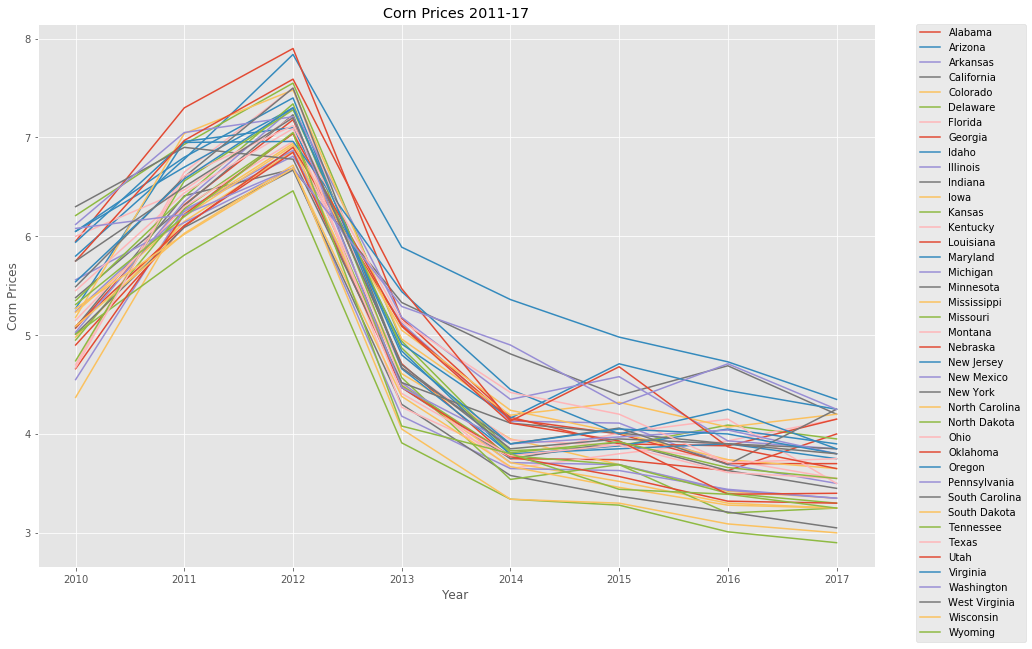

In [93]:
plot_all_states(corn_prices)
plt.xlabel("Year")
plt.ylabel('Corn Prices')
plt.title("Corn Prices 2011-17");